In [117]:
import pandas as pd

In [118]:
parse_dates = ['timestamp']

In [119]:
df = pd.read_csv("C:/Users/User/Downloads/data_lineage_synthetic_data - Sheet1.csv",parse_dates=parse_dates)

In [120]:
df.head(2)

,file_name,event_type,timestamp,user_iam,num_columns
0,price_daily,read,2017-07-04 13:23:55,price_team,10
1,price_weekly,write,2017-07-04 13:35:00,price_team,12


In [121]:
df.num_columns.unique()

array([10, 12, 14, 16, 22, 25, 27, 40, 42, 44], dtype=int64)

In [123]:
def bucket_num_columns(num_cols):
    if num_cols <= 10: return 1
    elif num_cols >10 and num_cols <=20 : return 2
    elif num_cols > 20 and num_cols <=30 : return 3
    elif num_cols > 30 and num_cols <=40 : return 4
    else : return 5
    

In [124]:
POSSIBLE_IAMS = df.user_iam.unique().tolist()
POSSIBLE_EVENTS = df.event_type.unique().tolist()

In [125]:
def encode_iams(user_iam): return POSSIBLE_IAMS.index(user_iam)
def encode_event_type(event_type) : return POSSIBLE_EVENTS.index(event_type)

In [126]:
def get_day_of_week(ts) : return ts.dayofweek
def get_day(ts) : return ts.day
def get_month(ts) : return ts.month
def get_year(ts) : return ts.year
def get_minutes(ts) : return ts.minute
def get_hour(ts) : return ts.hour

In [127]:
def get_qhr(hour, minute) : return hour * 4 +  (minute // 15)

In [137]:
cols_to_drop = df.columns.tolist()

In [129]:
feature_df = df.copy()

In [130]:
file_names = feature_df.file_name.tolist()

In [131]:
feature_df["col"] = feature_df.num_columns.apply(lambda x : bucket_num_columns(x))

In [132]:
feature_df["iam"] = feature_df.user_iam.apply(lambda x : encode_iams(x))

In [133]:
feature_df["event"] = feature_df.event_type.apply(lambda x : encode_event_type(x))

In [134]:
feature_df["day_of_week"] = feature_df.timestamp.apply(lambda x : get_day_of_week(x))
feature_df["day"] =  feature_df.timestamp.apply(lambda x : get_day(x))
feature_df["month"] = feature_df.timestamp.apply(lambda x : get_month(x))
feature_df["year"] = feature_df.timestamp.apply(lambda x : get_year(x))
feature_df["minute"] = feature_df.timestamp.apply(lambda x : get_minutes(x))
feature_df["hour"] = feature_df.timestamp.apply(lambda x : get_hour(x))
feature_df["qhr"] = feature_df.apply(lambda x : get_qhr(x["hour"],x["minute"]),axis =1)

In [135]:
feature_df.head(2)

,file_name,event_type,timestamp,user_iam,num_columns,col,iam,event,day_of_week,day,month,year,minute,hour,qhr
0,price_daily,read,2017-07-04 13:23:55,price_team,10,1,0,0,1,4,7,2017,23,13,53
1,price_weekly,write,2017-07-04 13:35:00,price_team,12,2,0,1,1,4,7,2017,35,13,54


In [138]:
cols_to_drop

['file_name', 'event_type', 'timestamp', 'user_iam', 'num_columns']

In [139]:
cols_to_drop += ["minute"]

In [140]:
cols_to_drop

['file_name', 'event_type', 'timestamp', 'user_iam', 'num_columns', 'minute']

In [141]:
feature_df.drop(columns=cols_to_drop,inplace=True)

In [142]:
new_feature_df = feature_df.copy()

In [143]:
new_feature_df.columns

Index(['col', 'iam', 'event', 'day_of_week', 'day', 'month', 'year', 'hour',
       'qhr'],
      dtype='object')

# Trying Bunch of clustering algorithms

### KMeans

In [146]:
from sklearn.cluster import KMeans

In [147]:
from sklearn.preprocessing import StandardScaler

In [150]:
X = new_feature_df.values

In [151]:
scaled_X = StandardScaler().fit_transform(X)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [152]:
cluster = KMeans().fit(X)

In [153]:
cluster.labels_

array([3, 5, 5, 1, 4, 2, 2, 6, 0, 7])

- Clustering is all over the place for basic KMeans

In [157]:
KMeans().fit(scaled_X).labels_

array([3, 7, 7, 1, 4, 0, 0, 6, 2, 5])

- Scaling not helping much

In [158]:
KMeans(n_clusters=3).fit(X).labels_

array([2, 2, 2, 2, 1, 1, 1, 0, 0, 0])

- When we know the number of clusters in prior, clustering is perfect in KMeans

In [159]:
KMeans(n_clusters=3).fit(scaled_X).labels_

array([1, 1, 1, 1, 2, 2, 2, 0, 0, 0])

- Same case with scaled

#### Finding optimal num_clusters through elbow method

In [168]:
sum_squared_distance = []
num_clusters = [_ for _ in range(2,10)]
for k in num_clusters:
    print(k)
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    print(km.labels_)
    sum_squared_distance.append(km.inertia_)

2
[0 0 0 0 0 0 0 1 1 1]
3
[0 0 0 0 2 2 2 1 1 1]
4
[0 0 0 0 3 2 2 1 1 1]
5
[3 0 0 0 4 2 2 1 1 1]
6
[5 2 2 2 4 0 0 3 1 1]
7
[3 6 6 0 4 2 2 5 1 1]
8
[4 2 2 6 0 3 3 5 1 7]
9
[3 2 2 6 4 0 0 5 1 7]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)


In [169]:
import matplotlib.pyplot as plt

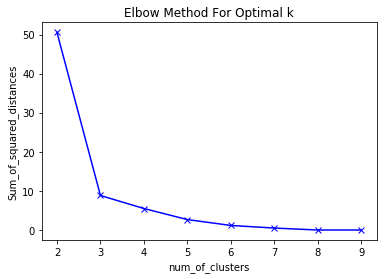

In [170]:
plt.plot(num_clusters, sum_squared_distance, 'bx-')
plt.xlabel('num_of_clusters')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

- Gives some clue that distances are making a sharp decline at number of cluster 3
- We could use this method for finding optimal number of clusters

# Hierarchial Clustering (Scipy)

In [172]:
import scipy.cluster.hierarchy as hcluster

In [182]:
t = 3
clusters = hcluster.fclusterdata(X, t, criterion="distance")

In [183]:
clusters

array([2, 2, 2, 2, 3, 3, 3, 1, 1, 1], dtype=int32)

In [184]:
clusters = hcluster.fclusterdata(scaled_X, t, criterion="distance")
clusters

array([1, 1, 1, 1, 3, 3, 3, 2, 2, 2], dtype=int32)

# Aglomerative Clustering

In [185]:
from sklearn.cluster import AgglomerativeClustering

In [186]:
cluster = AgglomerativeClustering(n_clusters=3).fit(X)


In [192]:
cluster.labels_

array([2, 2, 2, 2, 0, 0, 0, 1, 1, 1], dtype=int64)

# DBSCAN

In [194]:
from sklearn.cluster import DBSCAN

In [204]:
cluster = DBSCAN(min_samples =3).fit(X)

In [205]:
cluster

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=3, n_jobs=None, p=None)

In [206]:
cluster.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=int64)

# Spectral Clustering

In [208]:
from sklearn.cluster import SpectralClustering

In [209]:
SpectralClustering().fit(X).labels_

array([2, 6, 7, 5, 1, 0, 0, 3, 4, 4])

In [211]:
SpectralClustering(n_clusters=3).fit(X).labels_

array([2, 2, 2, 2, 0, 0, 0, 1, 1, 1])

In [212]:
clusters = SpectralClustering(n_clusters=3).fit(X)

In [214]:
clusters.affinity_matrix_

array([[1.00000000e+000, 4.97870684e-002, 4.97870684e-002,
        2.47875218e-003, 3.77513454e-011, 2.86251858e-020,
        2.86251858e-020, 1.27161079e-209, 2.45261912e-231,
        9.02268151e-232],
       [4.97870684e-002, 1.00000000e+000, 1.00000000e+000,
        3.67879441e-001, 3.05902321e-007, 9.35762297e-014,
        9.35762297e-014, 4.44227960e-190, 4.67799467e-210,
        1.27161079e-209],
       [4.97870684e-002, 1.00000000e+000, 1.00000000e+000,
        3.67879441e-001, 3.05902321e-007, 9.35762297e-014,
        9.35762297e-014, 4.44227960e-190, 4.67799467e-210,
        1.27161079e-209],
       [2.47875218e-003, 3.67879441e-001, 3.67879441e-001,
        1.00000000e+000, 4.53999298e-005, 7.58256043e-010,
        7.58256043e-010, 3.84672096e-173, 2.99318445e-192,
        8.13631891e-192],
       [3.77513454e-011, 3.05902321e-007, 3.05902321e-007,
        4.53999298e-005, 1.00000000e+000, 6.73794700e-003,
        6.73794700e-003, 4.69455094e-134, 1.47368188e-150,
        5.4

# Meanshift

In [216]:
 from sklearn.cluster import MeanShift

In [217]:
MeanShift().fit(X).labels_

array([4, 1, 1, 1, 3, 2, 2, 0, 0, 0], dtype=int64)

In [220]:
from sklearn.preprocessing import MinMaxScaler

In [221]:
minmaxX = MinMaxScaler().fit_transform(X)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [222]:
cluster = MeanShift().fit(minmaxX)

In [223]:
cluster.labels_

array([5, 0, 0, 0, 4, 2, 2, 1, 1, 3], dtype=int64)